In [1]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

from pprint import PrettyPrinter
# Configure pretty printer
pp = PrettyPrinter(compact=True)
print_ = lambda x: pp.pprint(x)

In [2]:
import json
import random
import pandas as pd

from pathlib import Path

from Utils.utils import PPT
from Config.config import PATHS
from Utils.interaction import Performer
from Utils.plot_utils import PlotVSMeasures
from Classes.cognitive_model_agents import (
    AttendanceM2, AttendanceM3, 
    MFPM2
)


## 2 Players

### Show AIC

In [12]:
file_2PL = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_2P.json')
df_2P = pd.read_json(file_2PL, lines=True)
df_2P.index = df_2P.model_name
df_parameters_2P = df_2P[['model_name', 'free_parameters']]
df_2P.drop(columns=['model', 'model_name', 'free_parameters', 'fixed_parameters'], inplace=True)
df_2P.sort_values(by='AIC', inplace=True)
# df_2P.sort_values(by='model_name', inplace=True)
df_2P['deviance'] = df_2P['deviance'].apply(lambda x: int(-x))
df_2P['AIC'] = df_2P['AIC'].apply(lambda x: int(x))
df_2P

,deviance,AIC
model_name,,
Payoff-M3,2867,5739
Payoff-M2,2867,5739
MFP-M1,3085,6174
Attendance-M2,3135,6276
Attendance-M3,3135,6276
Attendance-M1,3135,6276
Priors-M1,3136,6279
Priors-M3,3138,6295
WSLS-M3,3154,6315


In [15]:
file_2PL = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_2P_2.json')
df_2P = pd.read_json(file_2PL, lines=True)
df_2P.index = df_2P.model_name
df_parameters_2P = df_2P[['model_name', 'free_parameters']]
df_2P.drop(columns=['model', 'model_name', 'free_parameters', 'fixed_parameters'], inplace=True)
df_2P.sort_values(by='AIC', inplace=True)
# df_2P.sort_values(by='model_name', inplace=True)
df_2P['deviance'] = df_2P['deviance'].apply(lambda x: int(-x))
df_2P['AIC'] = df_2P['AIC'].apply(lambda x: int(x))
df_2P

,deviance,AIC
model_name,,
Attendance-M2,2333,4672
MFP-M2,2563,5131
AvailableSpace-M2,2785,5576
Fairness-M2,2859,5725
Payoff-M2,2867,5739
WSLS-M2,3154,6315
Priors-M2,3208,6442


In [14]:
file_2PL = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_2P_3.json')
df_2P = pd.read_json(file_2PL, lines=True)
df_2P.index = df_2P.model_name
df_parameters_2P = df_2P[['model_name', 'free_parameters']]
df_2P.drop(columns=['model', 'model_name', 'free_parameters', 'fixed_parameters'], inplace=True)
df_2P.sort_values(by='AIC', inplace=True)
# df_2P.sort_values(by='model_name', inplace=True)
df_2P['deviance'] = df_2P['deviance'].apply(lambda x: int(-x))
df_2P['AIC'] = df_2P['AIC'].apply(lambda x: int(x))
df_2P

,deviance,AIC
model_name,,
Attendance-M3,2333,4672
MFP-M3,2563,5131
AvailableSpace-M3,2785,5576
Payoff-M3,2867,5739
Fairness-M3,3075,6156
WSLS-M3,3154,6315
Priors-M3,3369,6756


In [9]:
latex_string = df_2P.to_latex()
print(latex_string)

\begin{tabular}{lrr}
\toprule
 & deviance & AIC \\
model_name &  &  \\
\midrule
Attendance-M2 & 2333 & 4672 \\
MFP-M2 & 2563 & 5131 \\
AvailableSpace-M2 & 2785 & 5576 \\
Fairness-M2 & 2859 & 5725 \\
Payoff-M2 & 2867 & 5739 \\
WSLS-M2 & 3154 & 6315 \\
Priors-M2 & 3208 & 6442 \\
\bottomrule
\end{tabular}



In [16]:
from Utils.LaTeX_utils import PrintLaTeX

latex_string_parameters = ''

for model, row in df_parameters_2P.iterrows():
    if model in ['Attendance-M2', 'Fairness-M2', 'Payoff-M2']:
        parameters = row['free_parameters']
        print('-'*60)
        print(model)
        print(parameters)
        # latex_string_parameters += r'\textbf\{' + model + '\}\n'
        # latex_string_parameters += PrintLaTeX.print_parameters(parameters)

# print(latex_string_parameters)

------------------------------------------------------------
Payoff-M2
{'inverse_temperature': 1.007205613492727, 'learning_rate': 0.30233257263183905}
------------------------------------------------------------
Attendance-M2
{'bias': 0.6582749870298511, 'inverse_temperature': 10.222250020841022, 'learning_rate': 0.135407345049286}
------------------------------------------------------------
Fairness-M2
{'bias': 0.182698657424529, 'inverse_temperature': 48.79424273649215, 'learning_rate': 0.0067400860222230005}


### Simulate best fit model

In [21]:
def get_free_parameters(model_name, params_dict):
    model_names = df_parameters_2P['model_name'].tolist()
    idx = model_names.index(model_name)
    return df_parameters_2P['free_parameters'][idx]

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

fixed_parameters = {
	"threshold":0.5,
	"num_agents":2,
}
free_parameters = get_free_parameters(BEST_MODEL.name(), df_parameters_2P)
print(free_parameters)
simulation_parameters = {
	'num_rounds':50,
	'verbose':False
}

{'bias': 0.6582749870298511, 'inverse_temperature': 10.222250020841022, 'learning_rate': 0.135407345049286}


In [22]:
data_folder = PATHS['parameter_fit_results'] / Path('MLE')
num_episodes = 23 # same as human groups
random.seed(1)
seeds = [random.randint(0, 1000) for _ in range(num_episodes)]

Performer.simple_run(
    agent_class=BEST_MODEL,
    fixed_parameters=fixed_parameters,
    free_parameters=free_parameters,
    simulation_parameters=simulation_parameters,
    measures=[],
    data_folder=data_folder,
    seeds=seeds
)


Running seeds...:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Data saved to /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/reports/MLE/Attendance-M2_55.csv


### Comparing with human data

In [23]:
# Loading human data
file_name = '2-player-UR.csv'
data_folder = Path('..', 'data', 'human')
file = data_folder / Path(file_name)
print(f'Loading data from {file}...')
data_human = pd.read_csv(file)
data_human.drop(columns=['room', 'choice'], inplace=True)
data_human['model'] = 'human'

# Loading simulated data

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

data_folder = PATHS['parameter_fit_results'] / Path('MLE')
file = data_folder / Path(f'{BEST_MODEL.name()}.csv')
print(f'Loading data from {file}...')
data_sim = pd.read_csv(file)
data_sim['model'] = BEST_MODEL.name()

df = PPT.concat_dfs(data_human, data_sim)
# df.head()

Loading data from ../data/human/2-player-UR.csv...
Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/reports/MLE/Attendance-M2.csv...


AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

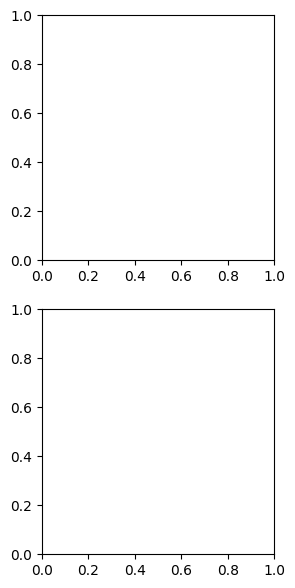

In [24]:
p = PlotVSMeasures(df)
# p = PlotVSMeasures(data_human)
# p = PlotVSMeasures(data_sim)
image_file = PATHS['parameter_fit_results'] / Path('MLE', f'two_way_comparisons.png')
measure_pairs = [['efficiency', 'attendance'], ['efficiency', 'inequality']]
p.two_way_comparisons(measure_pairs, image_file)

## All sizes

### Show AIC

In [ ]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all_with_treatment.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

# Keep only deviance and AIC columns
df_all.drop(columns=['model_name', 'free_parameters'], inplace=True)
# df_all.sort_values(by='model_name', inplace=True)
df_all.sort_values(by='AIC', inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all

,deviance,AIC,diff
model_name,,,
Attendance-M3,18129,36265,0
MFP-M2,18327,36659,394
MFP-M3,18370,36745,480
AvailableSpace-M3,18591,37186,921
Random,18609,37221,956
MFP-M1,18708,37421,1156
Attendance-M2,18834,37674,1409
Attendance-M1,18865,37737,1472
Fairness-M1,18955,37917,1652


In [32]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

# Keep only deviance and AIC columns
df_all.drop(columns=['model_name', 'free_parameters'], inplace=True)
# df_all.sort_values(by='model_name', inplace=True)
df_all.sort_values(by='AIC', inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all

,deviance,AIC,diff
model_name,,,
Attendance-M2,17626,35258,0
Attendance-M3,17947,35901,643
MFP-M2,18051,36106,848
MFP-M3,18148,36300,1042
MFP-M1,18187,36378,1120
Payoff-M1,18217,36438,1180
AvailableSpace-M3,18319,36643,1385
Payoff-M2,18339,36683,1425
Fairness-M3,18431,36869,1611


### Simulate best fit model

In [ ]:
# Load data into a dataframe
data_folder = Path('..', 'data', 'human')
file_names = [
	'2-player-UR.csv',
	'3-player-IU.csv',
	'4-player-IU.csv',
	'5-player-IU.csv',
	'6-player-IU.csv',
	'7-player-IU.csv',
	'8-player-IU.csv',
	'9-player-IU.csv',
	'11-player-IU.csv',
	'12-player-IU.csv',
]
df_list = list()
for file_name in file_names:
	file = data_folder / Path(file_name)
	print(f'Loading data from {file}...')
	df = pd.read_csv(file)
	df_list.append(df)
data_human = pd.concat(df_list, ignore_index=True)
columns = ['threshold', 'num_players', 'group', 'round', 'player', 'score', 'decision']
drop_columns = [col for col in data_human.columns if col not in columns]
data_human.drop(columns=drop_columns, inplace=True)
data_human['model'] = 'human'

In [ ]:
list_fixed_parameters = PPT.get_fixed_parameters(data_human)
list_simulation_parameters = PPT.get_number_of_groups(data_human)
dict_update = {
    'num_rounds':50,
    'verbose':False
}
for sim_p in list_simulation_parameters:
    sim_p.update(dict_update)
num_groups = len(list_simulation_parameters)
print(f'{len(list_fixed_parameters)} fixed parameters and {len(list_simulation_parameters)} simulation parameters')

In [ ]:
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')

with open(file_all, 'r') as f:
    params_dict = json.load(f)

def get_free_parameters(model_name, params_dict):
    model_names = params_dict['model_name']
    idx = model_names.index(model_name)
    return params_dict['free_parameters'][idx]

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

free_parameters = get_free_parameters(BEST_MODEL.name(), params_dict)
print_(free_parameters)

In [ ]:
data_folder = PATHS['parameter_fit_results'] / Path('MLE')

for i in range(num_groups):
    fixed_parameters = list_fixed_parameters[i]
    simulation_parameters = list_simulation_parameters[i]
    print(f'Running {BEST_MODEL.name()} with')
    print('Fixed parameters:')
    print_(fixed_parameters)
    print('Simulation parameters:')
    print_(simulation_parameters)
    random.seed(1)
    num_episodes = simulation_parameters['num_episodes']    
    seeds = [random.randint(0, 1000) for _ in range(num_episodes)]
    Performer.simple_run(
        agent_class=BEST_MODEL,
        fixed_parameters=fixed_parameters,
        free_parameters=free_parameters,
        simulation_parameters=simulation_parameters,
        measures=[],
        data_folder=data_folder,
        seeds=seeds
    )

### Compare with human data

In [ ]:
# Loading simulated data

# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2

data_folder = PATHS['parameter_fit_results'] / Path('MLE')

df_list = list()
for i in range(num_groups):
    file = data_folder / Path(f'{BEST_MODEL.name()}_{i+1}.csv')
    # print(f'Loading data from {file}...')
    data_sim = pd.read_csv(file)
    data_sim['model'] = BEST_MODEL.name()
    df_list.append(data_sim)

data_sim = pd.concat(df_list, ignore_index=True)

df = PPT.concat_dfs(data_human, data_sim)

In [ ]:
p = PlotVSMeasures(df)
image_file = PATHS['parameter_fit_results'] / Path('MLE', f'two_way_comparisons_all.png')
measure_pairs = [['efficiency', 'attendance'], ['efficiency', 'inequality']]
p.two_way_comparisons(measure_pairs, image_file)

### Simulate treatments

In [33]:
# Loading all models
file_all = Path(PATHS['parameter_fit_results'], 'MLE/best_fit_all.json')
df_all = pd.read_json(file_all)
df_all.index = df_all.model_name

# Create a dictionary with model names as keys and free parameters as values
df_parameters_all = dict(zip(df_all['model_name'], df_all['free_parameters']))

In [34]:
# BEST_MODEL = MFPM2
BEST_MODEL = AttendanceM2
# BEST_MODEL = AttendanceM3
free_parameters = df_parameters_all[BEST_MODEL.name()]
free_parameters

{'bias': 0.38169685922788604,
 'inverse_temperature': 6.258188362859529,
 'learning_rate': 0.134296558875471}

In [35]:
fixed_parameters = {
    'num_agents': 8, 
    'threshold': 0 # to be filled
}
simulation_parameters = {
    'num_episodes': 30, 
    'num_rounds': 50, 
    'verbose': 0
}
thresholds = [0.25, 0.5, 0.75]
data_folder = PATHS['parameter_fit_results'] / Path('MLE')
kwargs = {
    'model_name': BEST_MODEL.name(),
}

In [36]:
thresholds = [0.25, 0.5, 0.75]
kwargs = {
    'model_name': BEST_MODEL.name(),
    'with_treatment': True
}
Performer.increase_threshold(
    agent_class=BEST_MODEL,
    fixed_parameters=fixed_parameters,
    free_parameters=free_parameters,
    simulation_parameters=simulation_parameters,
    thresholds=thresholds,
    measures=['efficiency'],
    image_folder=data_folder,
    kwargs=kwargs
)

Running models for each threshold:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Plotting efficiency...
Plot saved to /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/reports/MLE/efficiency_threshold.png


'\n\\vspace{\\baselineskip}\n\n\n\nFree parameters:\n\n\\scalebox{0.8}{\n\\begin{minipage}{\\textwidth}\n\\begin{tabular}{ccc}\n\\toprule\nbias & inverse\\_temperature & learning\\_rate \\\\\n\\midrule\n0.38 & 6.26 & 0.13 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{minipage}\n}\n\n\\vspace{\\baselineskip}\n\n\\begin{tabular}{cc}\\toprule\n\n\\multicolumn{2}{c}{Parameter sweep}\\\\\n\nParameter & Values\\\\\\midrule\n\nthreshold & [0.25, 0.5, 0.75]\\\\\\bottomrule\n\n\\end{tabular}\n\n\n\\vspace{\\baselineskip}\n\n\\begin{tabular}{c}\n\\includegraphics[width=\\textwidth]{efficiency_threshold.png}\n\\end{tabular}\n'

In [10]:
# Load data into a dataframe
data_folder = Path('..', 'data', 'human')
file_names = [
#	'2-player-UR.csv',
	'3-player-IU.csv',
	'4-player-IU.csv',
	'5-player-IU.csv',
	'6-player-IU.csv',
	'7-player-IU.csv',
	'8-player-IU.csv',
	'9-player-IU.csv',
	'11-player-IU.csv',
	'12-player-IU.csv',
]
df_list = list()
for file_name in file_names:
	file = data_folder / Path(file_name)
	print(f'Loading data from {file}...')
	df = pd.read_csv(file)
	df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
columns = ['threshold', 'num_players', 'group', 'round', 'player', 'score', 'decision']
drop_columns = [col for col in data.columns if col not in columns]
data.drop(columns=drop_columns, inplace=True)
data.head()

Loading data from ../data/human/3-player-IU.csv...
Loading data from ../data/human/4-player-IU.csv...
Loading data from ../data/human/5-player-IU.csv...
Loading data from ../data/human/6-player-IU.csv...
Loading data from ../data/human/7-player-IU.csv...
Loading data from ../data/human/8-player-IU.csv...
Loading data from ../data/human/9-player-IU.csv...
Loading data from ../data/human/11-player-IU.csv...
Loading data from ../data/human/12-player-IU.csv...


,threshold,round,player,decision,score,num_players,group
0,0.333333,1.0,406360458182849,1.0,-1.0,3,17
1,0.333333,1.0,679877000681823,1.0,-1.0,3,17
2,0.333333,1.0,740425726975861,1.0,-1.0,3,17
3,0.333333,2.0,406360458182849,1.0,-1.0,3,17
4,0.333333,2.0,679877000681823,1.0,-1.0,3,17


In [11]:
for key, grp in data.groupby('group'):
    print(f'Group {key}')
    print(f'Threshold: {grp["threshold"].unique()}')

Group 5
Threshold: [0.25 0.5  0.75]
Group 7
Threshold: [0.875 0.625 0.375]
Group 9
Threshold: [0.25 0.5  0.75]
Group 11
Threshold: [0.875 0.625 0.375]
Group 12
Threshold: [0.8 0.6 0.4]
Group 13
Threshold: [0.27272727 0.45454545 0.63636364]
Group 14
Threshold: [0.4 0.6 0.8]
Group 15
Threshold: [0.25 0.5  0.75]
Group 17
Threshold: [0.33333333 0.66666667]
Group 18
Threshold: [0.75 0.5  0.25]
Group 22
Threshold: [0.33333333 0.66666667]
Group 23
Threshold: [0.4 0.6 0.8]
Group 24
Threshold: [0.33333333 0.66666667]
Group 25
Threshold: [0.75 0.5  0.25]
Group 26
Threshold: [0.8 0.6 0.4]
Group 27
Threshold: [0.25 0.5  0.75]
Group 29
Threshold: [0.25 0.5  0.75]
Group 30
Threshold: [0.66666667 0.33333333]
Group 31
Threshold: [0.25 0.5  0.75]
Group 32
Threshold: [0.42857143 0.71428571 1.        ]
Group 33
Threshold: [0.25 0.5  0.75]
Group 34
Threshold: [0.33333333 0.66666667]
Group 35
Threshold: [0.33333333 0.5        0.66666667]
Group 37
Threshold: [0.42857143 0.71428571 1.        ]
Group 38
Thres